In [1]:
from IPython.display import HTML

HTML("""<style>
.lev1 {margin-left: 80px}
.lev2 {margin-left: 100px}
.lev3 {margin-left: 120px}
.lev4 {margin-left: 140px}
.lev5 {margin-left: 160px}
.lev6 {margin-left: 180px}
</style>""")

# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Build-the-network" data-toc-modified-id="Build-the-network-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Build the network</a></div><div class="lev2 toc-item"><a href="#Loading-and-cleaning-the-full-dataset" data-toc-modified-id="Loading-and-cleaning-the-full-dataset-11"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Loading and cleaning the full dataset</a></div><div class="lev3 toc-item"><a href="#Methodological-note" data-toc-modified-id="Methodological-note-111"><span class="toc-item-num">1.1.1&nbsp;&nbsp;</span>Methodological note</a></div><div class="lev2 toc-item"><a href="#Select-runners" data-toc-modified-id="Select-runners-12"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Select runners</a></div><div class="lev2 toc-item"><a href="#Build-the-graph" data-toc-modified-id="Build-the-graph-13"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Build the graph</a></div><div class="lev2 toc-item"><a href="#Load-the-graph--from-edge-file" data-toc-modified-id="Load-the-graph--from-edge-file-14"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Load the graph  from edge file</a></div><div class="lev2 toc-item"><a href="#Draw-the-graph" data-toc-modified-id="Draw-the-graph-15"><span class="toc-item-num">1.5&nbsp;&nbsp;</span>Draw the graph</a></div><div class="lev1 toc-item"><a href="#Network-statistics" data-toc-modified-id="Network-statistics-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Network statistics</a></div><div class="lev2 toc-item"><a href="#Centralities-measures" data-toc-modified-id="Centralities-measures-21"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Centralities measures</a></div><div class="lev3 toc-item"><a href="#Degree" data-toc-modified-id="Degree-211"><span class="toc-item-num">2.1.1&nbsp;&nbsp;</span>Degree</a></div><div class="lev3 toc-item"><a href="#Betweenness-centrality" data-toc-modified-id="Betweenness-centrality-212"><span class="toc-item-num">2.1.2&nbsp;&nbsp;</span>Betweenness centrality</a></div><div class="lev2 toc-item"><a href="#Degree-Assortativity" data-toc-modified-id="Degree-Assortativity-22"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Degree Assortativity</a></div><div class="lev2 toc-item"><a href="#Clustering-coefficient" data-toc-modified-id="Clustering-coefficient-23"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Clustering coefficient</a></div><div class="lev2 toc-item"><a href="#Community-detection" data-toc-modified-id="Community-detection-24"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Community detection</a></div><div class="lev3 toc-item"><a href="#Analysing-communities" data-toc-modified-id="Analysing-communities-241"><span class="toc-item-num">2.4.1&nbsp;&nbsp;</span>Analysing communities</a></div><div class="lev4 toc-item"><a href="#Distance-among-communities" data-toc-modified-id="Distance-among-communities-2411"><span class="toc-item-num">2.4.1.1&nbsp;&nbsp;</span>Distance among communities</a></div>

<center>
<big><b>

Runner's Network analysis on full dataset 

</b></big>
</center>

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import datetime
from scipy import stats

import seaborn as sns
sns.set_context('notebook')
%config InlineBackend.figure_format = 'retina'

import powerlaw 
import networkx as nx
import itertools as itt

# Build the network 

We construct the runners' network where the _vertex are runners_ and links' weight are the __number of events the participate together__.

## Loading and cleaning the full dataset

In [219]:
full_df = pd.read_pickle('../../df_userID.pickle')
full_df.head(3)

,Race,Date,RaceYear,RaceMonth,Category,Distance,Name,Sex,Year,LivingPlace,Rank,Time,Pace,Place,MinTemp,MaxTemp,Weather,RaceID,UserID
0,Kerzerslauf,sam. 18.03.2000,2000,3,M20,15.0,Abgottspon Peter,M,1974.0,Zermatt,233,01:02:25,00:04:09,Kerzers,NaN,NaN,NaN,http://services.datasport.com/2000/lauf/kerzers,Abgottspon Peter 1974.0
1,Kerzerslauf,sam. 18.03.2000,2000,3,M35,15.0,Abplanalp Michael,M,1964.0,Bern,32,00:55:11.700000,00:03:40,Kerzers,NaN,NaN,NaN,http://services.datasport.com/2000/lauf/kerzers,Abplanalp Michael 1964.0
2,Kerzerslauf,sam. 18.03.2000,2000,3,M50,15.0,Abt Werner,M,1947.0,Spiez,155,01:12:42.900000,00:04:50,Kerzers,NaN,NaN,NaN,http://services.datasport.com/2000/lauf/kerzers,Abt Werner 1947.0


global transformations:

In [220]:
# in order to plot age (@time of the event!) instead of year of birth
full_df.Year = full_df.RaceYear - full_df.Year

# Round `Distance` feature:
full_df.Distance = full_df.Distance.round()
full_df.Distance = full_df.Distance.astype('int')

# transform timedelta in minutes!
full_df.Time = full_df.Time.astype('timedelta64[m]')

# transform Pace timedelta in sec!  - here is better to keep lower resolution!
full_df.Pace = full_df.Pace.astype('timedelta64[s]')

# these 2 are actually the same event!
full_df.Race = full_df.Race.apply(
    lambda x: 'Lucerne Marathon, Luzern' if x == 'SwissCityMarathon - Lucerne, Luzern' else x
)

### Methodological note

Even if there are few athelets that run more competition the same day, we assume we can neglet the case in which more than 1 runner does that, such that the links weights are not affected.   
With this assumption we can keep only the `RaceId`, as it's string that contraing already the _name and date_ of the race.

Removing useless features

In [221]:
full_df.drop(['MinTemp','MaxTemp','Weather',
              'LivingPlace','Rank','Category','Name',
              'Race','Date','RaceYear','RaceMonth','Place'],axis=1,inplace=True)
full_df.head(3)

,Distance,Sex,Year,Time,Pace,RaceID,UserID
0,15,M,26.0,62.0,249.0,http://services.datasport.com/2000/lauf/kerzers,Abgottspon Peter 1974.0
1,15,M,36.0,55.0,220.0,http://services.datasport.com/2000/lauf/kerzers,Abplanalp Michael 1964.0
2,15,M,53.0,72.0,290.0,http://services.datasport.com/2000/lauf/kerzers,Abt Werner 1947.0


In [5]:
full_df.UserID.nunique()

531426

## Select runners

Using all the runners  is computationally hard; furthermore it's maybe not to interesting to include runners that participated in very few events.

In [6]:
full_df.UserID.nunique()

531426

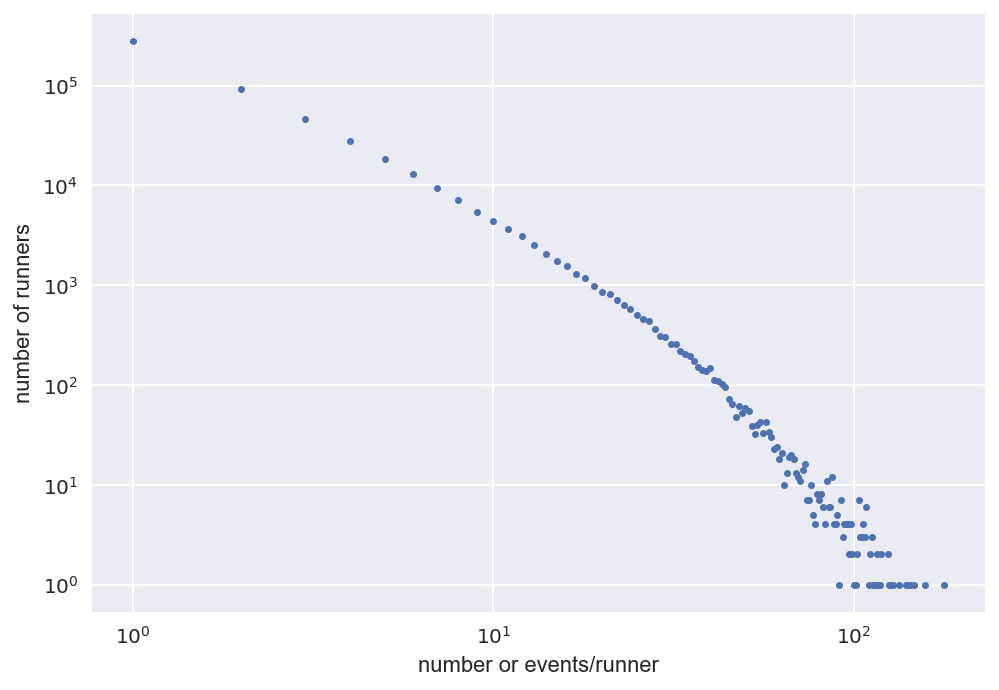

In [7]:
plt.loglog(full_df.UserID.value_counts().value_counts(),marker='.',linestyle='')
plt.xlabel('number or events/runner')
plt.ylabel('number of runners');

As suggested by the power-law fit in the notebook 'exploratory_full_sport_dataset',  a _good lower cut-off_ seems to be 
__events/runner = 70__

(MIND that this threshold identified by the power-law fit _might be already the good feature to distinguish pro/non-pro runners)

In [121]:
print('therefore, we will consider the most active runnuers n=',sum(full_df.UserID.value_counts()>70))

therefore, we will consider the most active runnuers n= 244


## Build the graph
(this part was acutally moved in __`parallel_network.py`__, where we parallelize the computation of the edges)

Extract the __enthusiasts__:

In [8]:
# single_events_counts = full_df.UserID.value_counts()

# enthusiasts = [k for k,v in single_events_counts.items() if v>70]

Create dictionary for __nodes__: 

In [43]:
# nodes_dict = dict.fromkeys(enthusiasts)

In [9]:
# here for simplicity we only take the first 10
# nodes_dict = dict.fromkeys(full_df.UserID.unique()[:10])

Define graph and add __nodes__:

In [10]:
# runner_graph = nx.Graph() # define graph
# runner_graph.add_nodes_from(nodes_dict.keys()) # add nodes

add __edges__:

In [9]:
# %%time

# for c in itt.combinations(nodes_dict.keys(),2):

#     c0_races = full_df[full_df.UserID==c[0]].RaceID.unique()
#     c1_races = full_df[full_df.UserID==c[1]].RaceID.unique()
#     n_shared_race = len(set(c0_races) & set(c1_races))
# #     print('# shared rances between',c[0],c[1],'=',n_shared_race)
    
#     if n_shared_race!=0:

#         runner_graph.add_edge(c[0],c[1],weight = n_shared_race)

CPU times: user 10.2 s, sys: 25.4 ms, total: 10.2 s
Wall time: 10.2 s


in case you wanna save the whole graph:

In [ ]:
# nx.write_gpickle(runner_graph,'runner_graph')
# trial_graph = nx.read_gpickle('runner_graph')   ## <-- how to read it back!

## Load the graph  from edge file

In [12]:
import pickle

In [110]:
with open('big_outfile.txt','rb') as f:
     big_edge_list = pickle.load(f)

In [111]:
# # # this is the computation run on a small subset of nodes

# with open('outfile.txt','rb') as f:
#      edge_list = pickle.load(f)

remove `None` edges:

In [112]:
len(big_edge_list)

29646

In [113]:
big_edge_list = [e for e in big_edge_list if e is not None]

In [114]:
len(big_edge_list)

29036

In [116]:
runner_graph = nx.from_edgelist(big_edge_list)

mind that the graph is 'quite well' connected: 

In [122]:
n_nodes = len(runner_graph.nodes())

In [124]:
print('# edges of connected graph:',n_nodes*(n_nodes-1)/2)
print('# edges of our graph:',len(runner_graph.edges()))

# edges of connected graph: 29646.0
# edges of our graph: 29036


## Draw the graph   
(credits to [this answer on SO](credits to http://stackoverflow.com/questions/21711184/drawing-a-large-weighted-network-in-networkx-based-on-thickness))

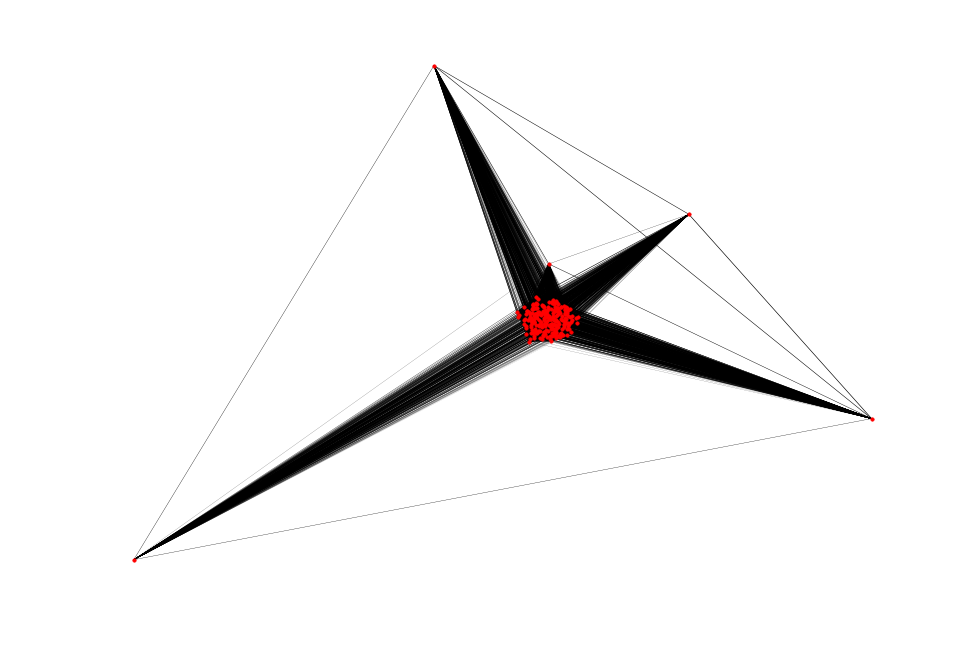

In [131]:
# choose the layout
pos = nx.spring_layout(runner_graph)

# get edge weight to use as width in the plot
edgewidth = [ d['weight'] for (u,v,d) in runner_graph.edges(data=True)]

# acutal plot
nx.draw_networkx_nodes(runner_graph, pos,node_size=3)
nx.draw_networkx_edges(runner_graph, pos, width = np.array(edgewidth)/100.0)
plt.axis('off');

# Network statistics 

## Centralities measures

### Degree

MIND that the degree distribution  _might be strongly affected_ by the cut off we set for the construction of the graph

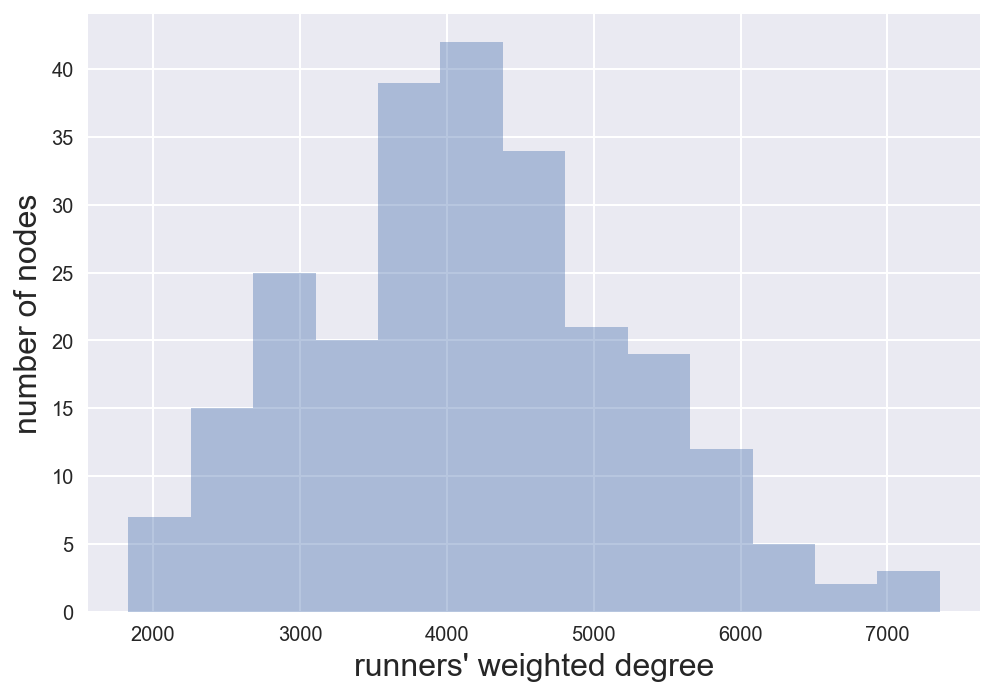

In [132]:
degree_runners = runner_graph.degree(weight='weight')

sns.distplot(list(degree_runners.values()),kde=False)
plt.ylabel('number of nodes',size=16)
plt.xlabel('runners\' weighted degree',size=16);

### Betweenness centrality

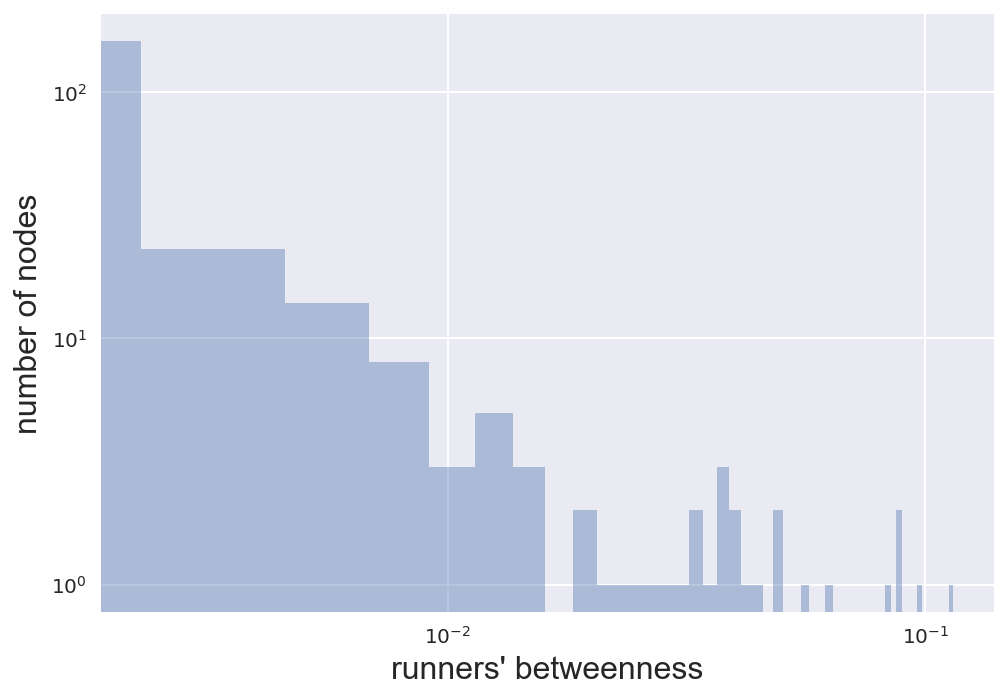

In [135]:
betweenness_runners = nx.betweenness_centrality(runner_graph,weight='weight')

sns.distplot(list(betweenness_runners.values()),kde=False)
plt.xscale('log')
plt.yscale('log')
plt.ylabel('number of nodes',size=16)
plt.xlabel('runners\' betweenness',size=16);

## Degree Assortativity

In [136]:
nx.degree_assortativity_coefficient(runner_graph,weight= 'weight')

-0.014173795136821748

We can conclude that the graph is __not assortative__ on the degree. This means that runners that have many connections _don't tend_ to run in races where there are other highly connected runners.

## Clustering coefficient

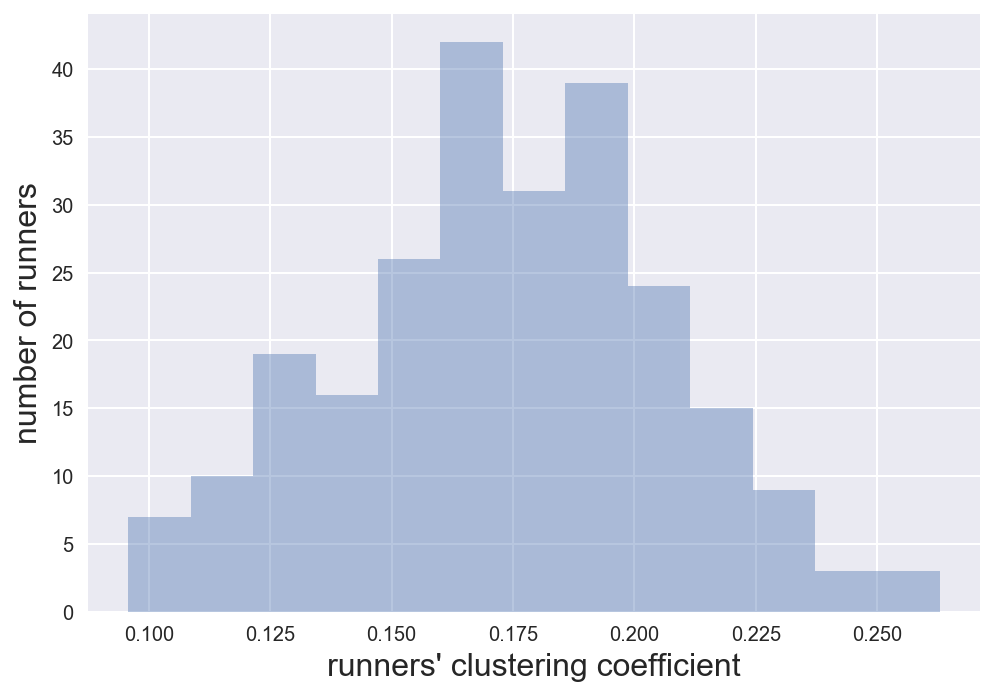

In [137]:
clustering_runners = nx.clustering(runner_graph,weight='weight')

sns.distplot(list(clustering_runners.values()),kde=False)
plt.ylabel('number of runners',size=16)
plt.xlabel('runners\' clustering coefficient',size=16);

here we check the 'usual' anti-correlation between betweenness_centrality and clustering coefficient:

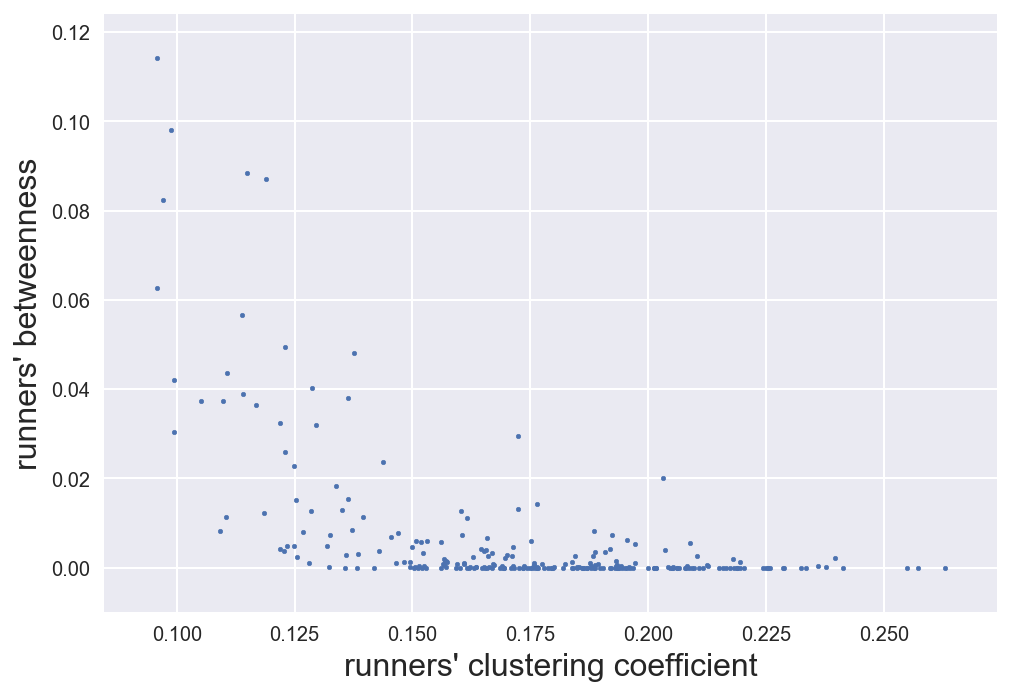

In [141]:
plt.scatter(np.fromiter(clustering_runners.values(),dtype=float),
            np.fromiter(betweenness_runners.values(),dtype=float),s=5)

plt.xlabel('runners\' clustering coefficient',size=16)
plt.ylabel('runners\' betweenness',size=16);

## Community detection

In [142]:
import community

Compute the best partition:

In [143]:
partition = community.best_partition(runner_graph)

print('number of communities:', len(set(partition.values())))

number of communities: 3


Drawing communities on graph:

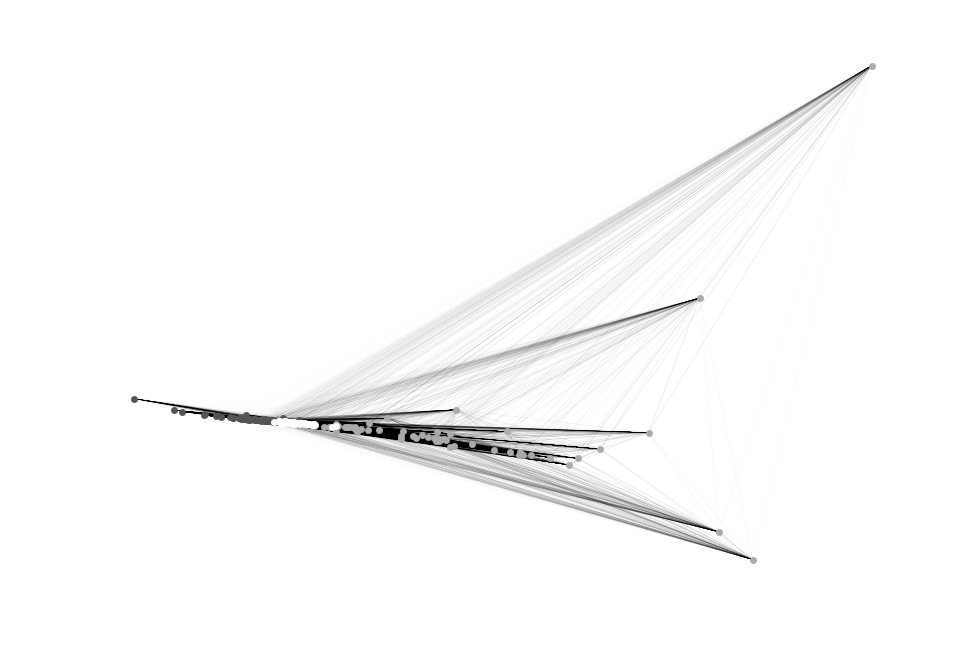

In [147]:
size = float(len(set(partition.values())))
# pos = nx.spring_layout(runner_graph)
pos = nx.spectral_layout(runner_graph)

count = 0.
for com in set(partition.values()) :
    count = count + 1.
    list_nodes = [nodes for nodes in partition.keys()
                                if partition[nodes] == com]
    nx.draw_networkx_nodes(runner_graph, pos, list_nodes, node_size = 10,
                                node_color = str(count / size))


nx.draw_networkx_edges(runner_graph,pos, width = np.array(edgewidth)/1000.0)
plt.axis('off')
plt.show();

### Analysing communities

community N 0

In [158]:
comm0 = [k for k,v in partition.items() if v==0]

In [160]:
comm1 = [k for k,v in partition.items() if v==1]

In [161]:
comm2 = [k for k,v in partition.items() if v==2]

In [187]:
communities_df = pd.DataFrame([len(comm0),len(comm1),len(comm2)])
communities_df.columns = ['number_nodes']
communities_df

,number_nodes
0,137
1,56
2,51


Assign community number to each runner that is part of the graph, _in the original dataframe_:

In [224]:
full_df['community'] = None

In [225]:
%%time
for r in runner_graph.nodes():
    
    full_df.community[full_df.UserID==r] = partition[r]

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


CPU times: user 1min 15s, sys: 366 ms, total: 1min 15s
Wall time: 1min 15s


In [207]:
full_df.head()

,Distance,Sex,Year,Time,Pace,RaceID,UserID,community
0,15.0,M,1974.0,01:02:25,00:04:09,http://services.datasport.com/2000/lauf/kerzers,Abgottspon Peter 1974.0,None
1,15.0,M,1964.0,00:55:11.700000,00:03:40,http://services.datasport.com/2000/lauf/kerzers,Abplanalp Michael 1964.0,None
2,15.0,M,1947.0,01:12:42.900000,00:04:50,http://services.datasport.com/2000/lauf/kerzers,Abt Werner 1947.0,None
3,15.0,F,1953.0,01:22:36.700000,00:05:30,http://services.datasport.com/2000/lauf/kerzers,Ackermann Antoinette 1953.0,None
4,15.0,F,1946.0,01:23:29.300000,00:05:33,http://services.datasport.com/2000/lauf/kerzers,Ackermann Hedy 1946.0,None


#### Distance among communities

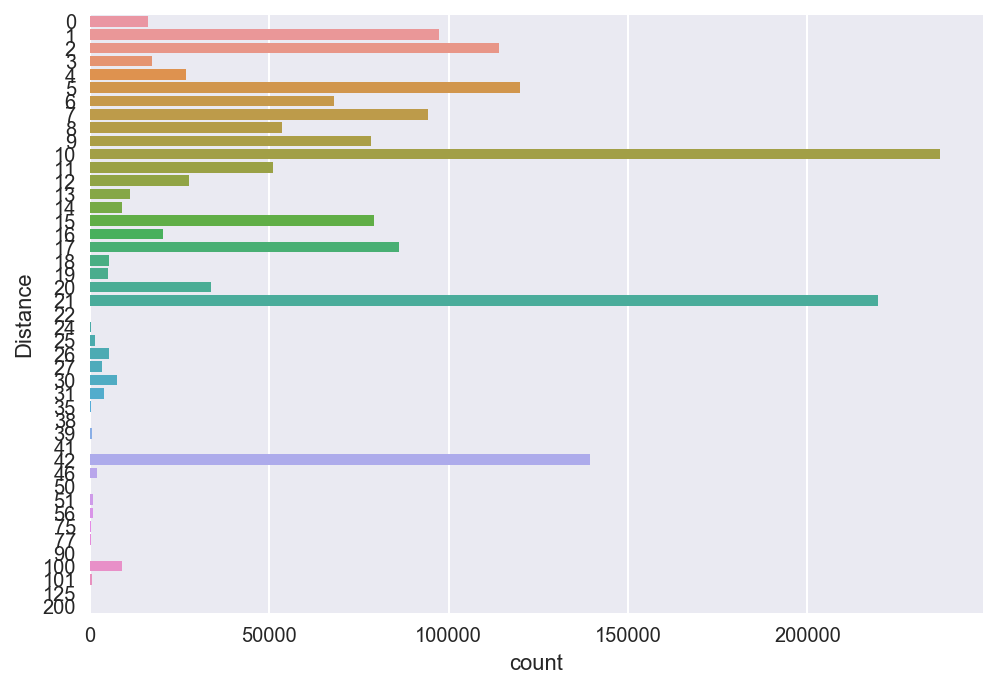

In [222]:
sns.countplot(y=full_df.Distance);

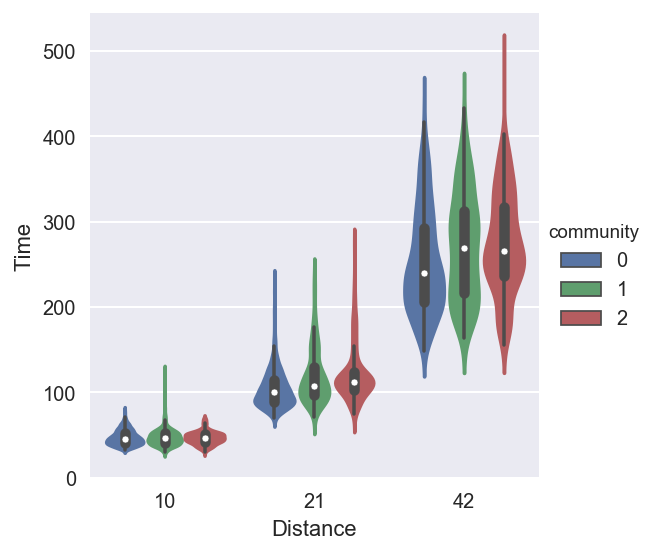

In [227]:
sns.factorplot(data=full_df[full_df.Distance.isin([10,21,42])],
               y='Time',x='Distance',
               kind='violin',hue='community');

Time __doesn't seem to be a discriminant feature__ among communities  - no stat. test was run though...